In [2]:
import os
import re
import string
import zipfile
import numpy as np
import tensorflow
from os import path
from collections import Counter
from urllib.request import urlretrieve
import sklearn
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
import unidecode
EPSILON = 1e-15

### I - Loading and visualizing pre-trained embeddings

Two 100 dimensional pre-trained word embeddings are available here:
- GloVe
- Word2vec

To measure similarity between vectors, we often use the cosine similarity.
(https://en.wikipedia.org/wiki/Cosine_similarity)
$cosine\_similarity(w_1, w_2) = \Large \frac{\langle w_1, w_2 \rangle}{||w_1|| \cdot ||w_2||} = \frac{w_1^T \cdot w_2}{||w_1|| \cdot ||w_2||}$

$w_1$ and $w_2$ are two word vector embeddings.

It is a measure of how aligned $w_1$ and $w_2$ are.

In [5]:
class PretrainedEmbeddings():
    def __init__(self, language, embeddings):
        self.vec_file = None
        if language == 'en':
            if embeddings == 'glove':
                self.vec_file = 'glove_100k.en.vec.zip'
            elif embeddings == 'w2v':
                self.vec_file = 'w2v_1600k.en.vec.zip'
        elif language == 'fr':
            if embeddings == 'glove':
                print('No GloVe french embeddings!')
                return None
            elif embeddings == 'w2v':
                self.vec_file = 'w2v_800k.fr.vec.zip'
        self.language = language
        self.url = "https://github.com/Deep-Learning-courses/courses_labs/releases/download/0.1/" + self.vec_file
        self.file_location_compressed = os.path.join('data', self.vec_file)
        self.file_location = self.file_location_compressed.replace('.zip', '')
        self.embeddings_index = None
        self.embeddings_index_inversed = None
        self.embeddings_vectors = None
        self.voc_size = None
        self.dim = None
    
    @staticmethod
    def _normalize(array):
        return array / np.linalg.norm(array, axis=-1, keepdims=True)
        
    def download_and_extract(self):
        if not path.exists(self.file_location):
            print('Downloading from %s to %s...' % (self.url, self.file_location_compressed))
            urlretrieve(self.url, self.file_location_compressed)
            print('Downloaded embeddings')
            print('Extracting from %s to %s...' % (self.file_location_compressed, self.file_location))
            with zipfile.ZipFile(self.file_location_compressed, 'r') as zip_ref:
                zip_ref.extractall('data')
            os.remove(self.file_location_compressed)
    
    """
    Note that you can choose to normalize directly the embeddings 
    to make the cosine similarity computation easier afterward.
    """
    def load(self, normalize=False):
        self.embeddings_index, self.embeddings_index_inversed = {}, {}
        self.embeddings_vectors = []
        file = open(self.file_location, encoding='utf-8')
        header = next(file)
        self.voc_size, self.dim = [int(token) for token in header.split()]
        print('Vocabulary size: {0}\nEmbeddings dimension: {1}'.format(self.voc_size, self.dim))
        print('Loading embeddings in memory...')
        for idx, line in enumerate(file):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            self.embeddings_index[word] = idx
            self.embeddings_index_inversed[idx] = word
            self.embeddings_vectors.append(vector)
        self.embeddings_vectors = np.asarray(self.embeddings_vectors)
        print('Embeddings loaded')
        if normalize:
            self.embeddings_vectors = self._normalize(self.embeddings_vectors)
            print('Embeddings normalized')
        file.close()
    
    """ 
    Return an embedding vector associated to a given word.
    For this you are supposed to used the objects defined in the load function.
    Be sure to handle the case where the received word is not found in the embeddings' vocabulary.
    """
    def word_to_vec(self, word):
        # TODO:
        #search for index according to word argument
        try:
            index = self.embeddings_index[word]
            vec = self.embeddings_vectors[index]
        except KeyError:
            print("{} does not appear in the vocabulary".format(word))
            return None
        return vec
    
    """
    Return the closest word associated to a given embedding vector
    The vector passed as argument might not be in self.embeddings_vectors
    In other terms, you have to compute every cosine similarity between the vec argument
    and the embeddings found in self.embeddings_vectors. Then determine the embedding in 
    self.embeddings_vectors with the highest similarity and return its associated string word
    """
    def vec_to_closest_word(self, vec):
        # TODO:
        if vec is None:
            print("vec is not defined")
            return None
        #test for maximum similarity
        max_sim = 0
        max_index = 0
        #test all embeddings
        for index,embedding in enumerate(self.embeddings_vectors):
            similarity = np.dot(vec.T,embedding)/np.dot(np.linalg.norm(vec),np.linalg.norm(embedding))
            if similarity > max_sim:
                max_sim = similarity
                max_index = index
        #retrieve word according to maximum similarity
        word = self.embeddings_index_inversed[max_index]
        return word
    
    """
    Return the n top similar words from a given string input.
    The similarities are based on the cosine similarities between the embeddings vectors.
    Note that the string could be a full sentence composed of several words.
    Split the sentence, map the words that can be found in self.embeddings_vectors to vectors and
    average them. 
    Then return the top (default: top=10) words associated to the top embeddings
    in self.embeddings_vectors that have the highest cosine similarity with the previously computed average.
    """
    def most_similar(self, query, top=10):
        # TODO:
        vectors = []
        sim_dict = {}
        most_similar_words = []
        #split the sentence into words
        words = query.split()
        #for each word, map it to a word embedding 
        for word in words:
            vectors.append(self.word_to_vec(word))
        #remove all None values if the word does not appear in dictionnary
        vectors = [vec for vec in vectors if vec is not None]                
        #average all the embeddings
        avg_vec = np.mean(vectors,axis=0)
        
        #create similarity dictionnary with the form {index : similarity}
        for index,embedding in enumerate(self.embeddings_vectors):
            similarity = np.dot(avg_vec.T,embedding)/np.dot(np.linalg.norm(avg_vec),np.linalg.norm(embedding))
            sim_dict[index] = similarity
        #select the index of top similar entries of the dictionnary
        top_index = {k[0] for k in sorted(sim_dict.items(), key=lambda x: x[1], reverse=True)[:top]}
        #for each index, retrieve the associated word
        for index in top_index:
            most_similar_words.append(self.embeddings_index_inversed[index])
        return most_similar_words
    
    def project_and_visualize(self, sample=1000):
        embeddings_tsne = TSNE(perplexity=30).fit_transform(self.embeddings_vectors[:sample])
        plt.figure(figsize=(40, 40))
        axis = plt.gca()
        np.set_printoptions(suppress=True)
        plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], marker=".", s=1e-6)
        for idx in range(sample):
            plt.annotate(
                self.embeddings_index_inversed[idx],
                xy=(embeddings_tsne[idx, 0], embeddings_tsne[idx, 1]),
                xytext=(0, 0), textcoords='offset points'
            )

In [6]:
pretrained_embeddings = PretrainedEmbeddings(language='en', embeddings='glove')
pretrained_embeddings.download_and_extract()
pretrained_embeddings.load(normalize=True)

Downloaded embeddings
Extracting from data/glove_100k.en.vec.zip to data/glove_100k.en.vec...
Vocabulary size: 100000
Embeddings dimension: 100
Loading embeddings in memory...
Embeddings loaded
Embeddings normalized


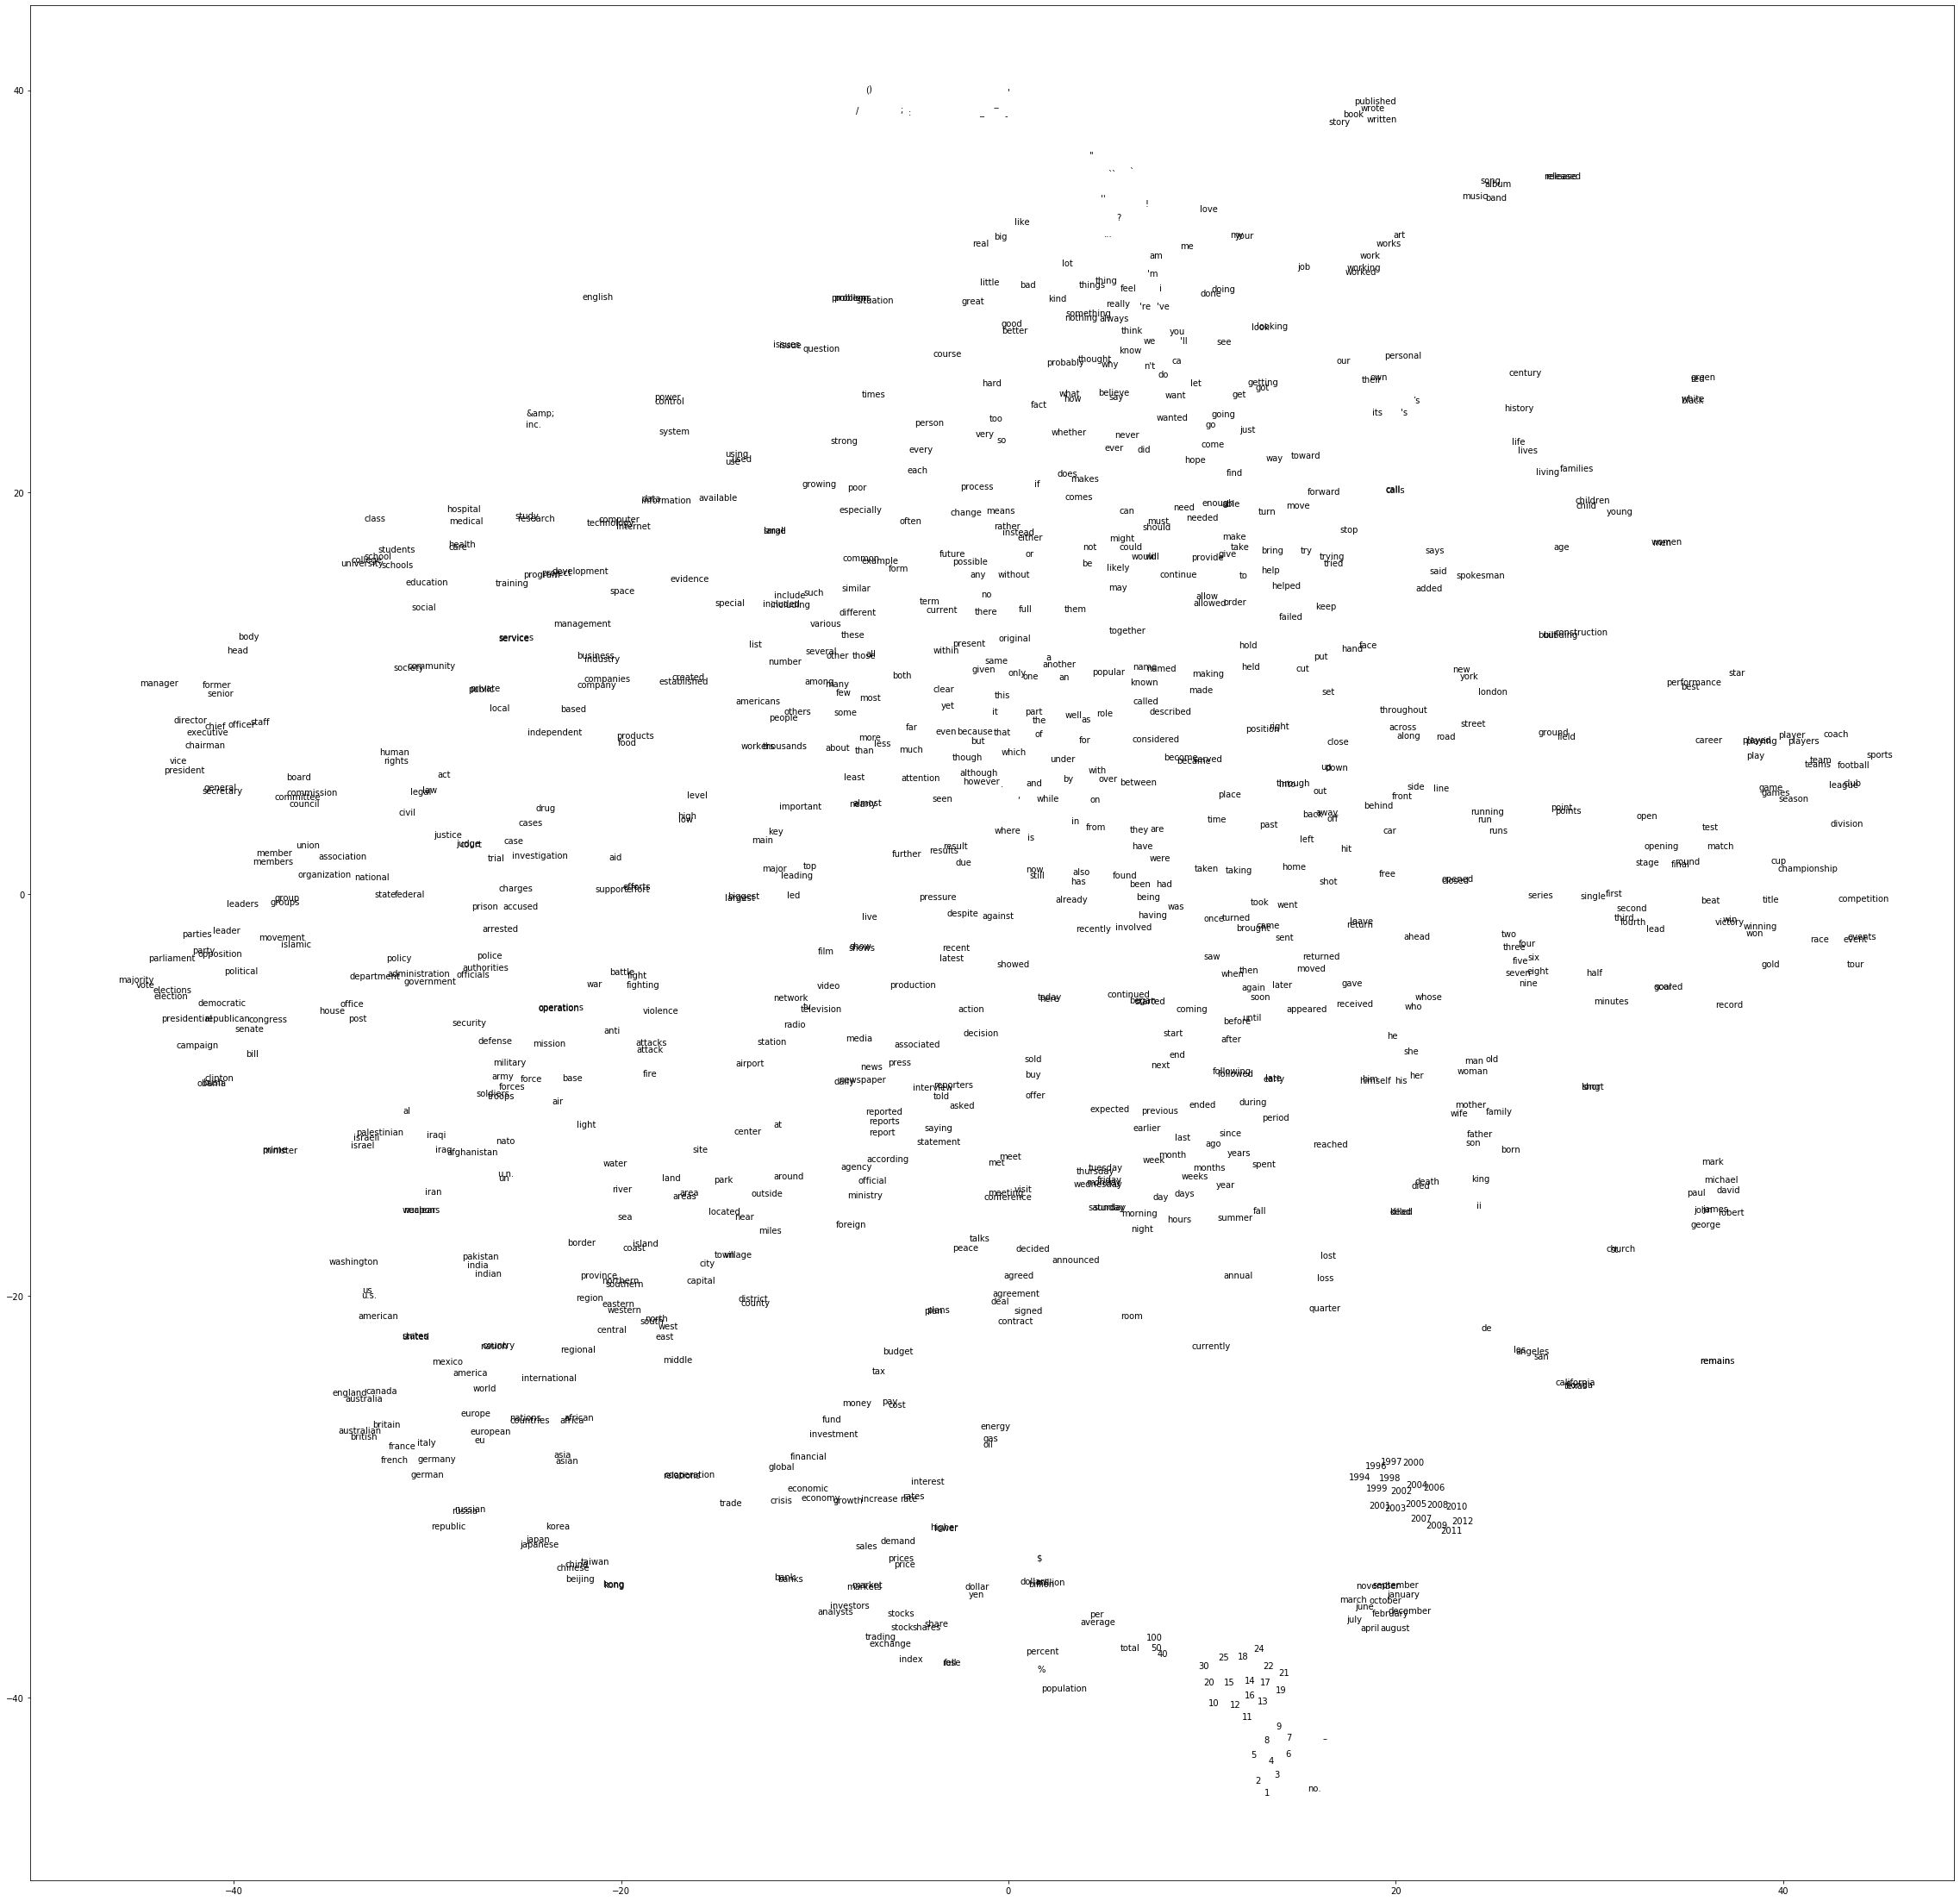

In [7]:
pretrained_embeddings.project_and_visualize()

In [8]:
pretrained_embeddings.vec_to_closest_word(pretrained_embeddings.word_to_vec('language'))

'language'

In [8]:
pretrained_embeddings.most_similar('beef and chicken')

['fish',
 'chicken',
 'vegetables',
 'beef',
 'milk',
 'pork',
 'food',
 'lamb',
 'poultry',
 'meat']

## Questions:

#### • Observe the visualization plot. <br> &rarr; What can you say about very common words?<br> &rarr; Are you able to identify some clusters catching a specific semantical concept?  
 - Very common words, such as linking and transition words, seem to be at the center of a lot of clusters. This can be explained by their frequency of appearance in every sentence, making them appear in a lot of context and as such, have a similar embedding to a lot of words.
 - With this t-SNE visualisation, we can identify semantical clusters, such as:
    - Family (father, mother, wife, family, ...)
    - Numbers
    - First names (paul, michael, mark, robert ...)
    - Education (university, college, school, ...)
    - Economy (stocks, trading, exchange, investors, ...)

#### • What may be happen if you try to call the "most similar" method with a very long sentence? Will it be accurate? Why?
 - The most similar method will be less accurate with a very long sentence, because we average the embeddings of every single word in the sentence. The embedding of each individual word will have less weight and in consequence, will be lost.
 - Furthermore, the complexity of our implementation of the most similar method is very high because we generate a dictionnary of similarity with the whole vocabulary and then do complex operations such as sorting it. A long sentence will take a long time to compute.  


### II - Language modelling

#### Sampling random text from the model

First part of language modelling will be about predicting the next character of a finite sequence of characters of size $k$.

Recursively generate one character at a time: your model outputs the probability distribution $p_{\theta}(c_{n} | c_{n-1}, \ldots, c_{n-k})$

Using this probability distribution, a predicted character $c_{n}$ will be sampled. The temperature parameter makes it possible to remove additional entropy (bias) into the parameterized multinoulli distribution of the output of the model.

Then use your prediction $c_{n}$ to compute $c_{n+1}$, your model outputs: $p_{\theta}(c_{n+1} | c_{n}, \ldots, c_{n-k+1})$, and so on

In [9]:
class LanguageModel():
    def __init__(self):
        self.corpus_path = None
        self.corpus = None
        
    def _get_contiguous_sample(self, corpus, size):
        print(len(corpus), size)
        index = np.random.randint(0, len(corpus) - size + 1)
        return corpus[index:index+size]
    
    def load_data(self, corpus_path, proportion_to_keep=1):
        assert 0 <= proportion_to_keep <= 1, "proportion_to_keep should be between 0 and 1"
        self.corpus_path = os.path.join('data', corpus_path)
        file = open(self.corpus_path)
        entire_corpus = file.read()
        self.corpus = unidecode.unidecode(
            self._get_contiguous_sample(
                entire_corpus, size=int(proportion_to_keep*len(entire_corpus))
            ).lower().replace("\n", " ")
        )
        print('Corpus length: {0} characters'.format(len(self.corpus)))
        file.close()
        
    def plot_vocabulary_distribution(self):
        counter = Counter(self.corpus)
        chars, counts = zip(*counter.most_common())
        indices = np.arange(len(counts))
        plt.figure(figsize=(16, 5))
        plt.bar(indices, counts, 0.8)
        plt.xticks(indices, chars)

In [10]:
sample_size = 500

language_model = LanguageModel()
language_model.load_data('lambada_cleaned_sample.txt', proportion_to_keep=1e-4)
print('Loaded sample:\n{0}'.format(language_model.corpus))

10000000 1000
Corpus length: 1000 characters
Loaded sample:
 as it almost toppled off the arm. o bottle of booze beloved! he snickered. the cellar was a haze of gelatin around his bobbing head. he tilted back the bottle and let the whisky trickle hot in his throat, burning in his stomach. his eyes watered. i am drinking catherine! his mind cried fiercely. i have distilled her, synthesizing loins and breasts and stomach and sixteen years of them into a conflagrating liquor, which i drink, so. his throat moved convulsively as the whisky gurgled down. drink, drink! and it shall make thy belly bitter, but it shall be in thy mouth sweet as honey. drunk i am and drunk i mean to stay, he thought. he wondered why it had never occurred to him before. this bottle that he held before him now had stood in the cupboard for three months and, before that, two months in the old apartment. five months of suffering neglect. he patted the brown glass bottle ; he kissed it fervently. i kiss thee, catherin

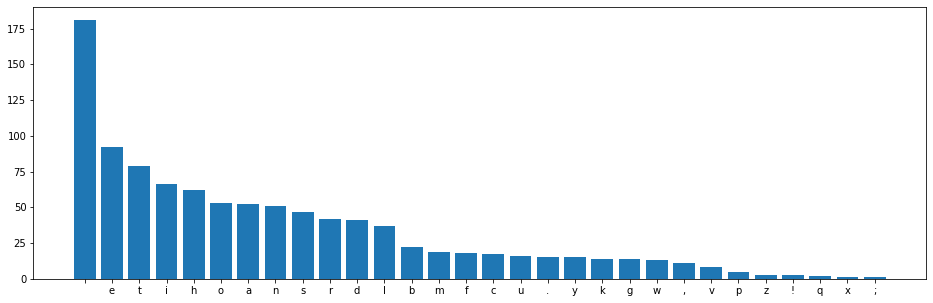

In [11]:
language_model.plot_vocabulary_distribution()

### II - a) Character-based language modelling

#### Measuring per-character perplexity

To measure the quality of a language model we usually use the perplexity.
(https://en.wikipedia.org/wiki/Perplexity)

Here is how it is defined:

$$perplexity_\theta = 2^{-\frac{1}{n} \sum_{i=1}^{n} log_2 (p_\theta(c_i)^T\cdot y_i)}$$
$p_\theta(c_i)$ is your predicted column vector of probabilities over the possible next characters for the $i^{th}$ sequence.
$y_i$ is the one-hot encoding vector of the answer: the next character of the $i^{th}$ sequence.

You just compute the average negative loglikelihood like you have done previously, only using a log2 logarithm. Then just perform a base $2$ exponentiation of the quantity just computed.

In [12]:
"""
tensorflow.keras imports
"""
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer

In [13]:
"""
Character based langage model implementation
corpus_path: path of the corpus to load
proportion_to_keep: contiguous proportion of the corpus that will be stored in memory
hidden_size: hidden layer dimension
char_embedding: if set to True, a dense embedding layer will be trained
embedding_size: embedding layer dimension if char_embedding is True
model: pre-trained model to use
"""

class CharLanguageModel(LanguageModel):
    def __init__(self, corpus_path, proportion_to_keep=1,
                 hidden_size=256, char_embedding=False, embedding_size=32, model=None):
        super(LanguageModel, self).__init__()
        self.char_index = None
        self.char_index_inversed = None
        self.vocabulary_size = None
        self.max_length_sequence = None
        self.X = None
        self.y = None
        self.hidden_size = hidden_size
        self.char_embedding = char_embedding
        self.embedding_size = embedding_size
        self.load_data(corpus_path, proportion_to_keep)
        self.extract_vocabulary()
        self.build_dataset()
        self.model = self._get_model() if model is None else model
        
    """
    Define and compile a tensorflow.keras model, it will deal with sequences of length max_length_sequence
    The representation size depends on the tokens' representation you chose
    It should be composed of :
        - an optional Embedding layer projecting into embedding_size dimensions: it will learn a distributed
        representation of the given vocabulary
        - one recurrent LSTM layer projecting into hidden_size dimensions
        - one Dense layer with a softmax activation projecting into vocabulary_size dimensions
    """
    def _get_model(self):
        representation_size = self.embedding_size if self.char_embedding else self.vocabulary_size
        # TODO:
        model = Sequential()
        # Add an Embedding layer expecting input vocab of size self.max_length_sequence, and
        # output embedding dimension of size representation_size.
        if self.char_embedding:
            model.add(Embedding(input_dim= self.vocabulary_size, output_dim=representation_size, mask_zero=True,input_length=self.max_length_sequence))
        else:
            model.add(Input(shape=(self.max_length_sequence, representation_size)))
        # Add a LSTM layer with self.hidden_size internal units.
        model.add(LSTM(self.hidden_size))

        # Add a Dense layer with self.vocabulary_size units and softmax activation.
        model.add(Dense(self.vocabulary_size, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    def extract_vocabulary(self):
        chars = sorted(set(self.corpus))
        self.char_index = dict((c, i) for i, c in enumerate(chars))
        self.char_index_inversed = dict((i, c) for i, c in enumerate(chars))
        self.vocabulary_size = len(self.char_index)
        print('Vocabulary size: {0}'.format(self.vocabulary_size))
        
    """
    Methods to convert X into an encoded matrix
    
    Importante note: if the sequence length if smaller than max_length_sequence, 
    we pad the input with zeros vectors at the beginning of the encoded matrix
    
    Hints:
      - You can use the sequence method from tensorflow.keras.preprocessing to pad the received sequences
      - You can use the to_categorical method from tensorflow.keras.utils with a specified num_classes parameters to 
        one-hot encode your data
    """


    def _integer_encoding(self, X):
        seq_int=[]
        for line in X:
            line_int=[]
            for i,char in enumerate(line):
                if i==0:
                    line_int = [self.char_index[char]]
                else:
                    line_int.append(self.char_index[char])
            seq_int.append(line_int)
        #print("X[2]: ", X[2])
        #print("seq_int[2]: ", seq_int[2])
        seq = sequence.pad_sequences(seq_int,maxlen=self.max_length_sequence, dtype='int32')
        #print("seq[0] :", seq[0], "\n")
        return seq

    
    def _one_hot_encoding(self, X):
        # TODO:
        toint = self._integer_encoding(X)
        return to_categorical(toint,num_classes=self.vocabulary_size)
    
    """
    The matrices X and y are created in this method
    It consists of sampling contiguous chunks in the corpus as training vectors with the next character as target
    Then, an encoding method is called depending on the tokens' representation you chose to use in your model
    """
    def build_dataset(self, min_length_sequence=5, max_length_sequence=30, step=10, trunc_freq=0.05):
        self.X, self.y = [], []

        for i in range(0, len(self.corpus)-max_length_sequence, step):
            length_sequence = max_length_sequence
            if np.random.rand() < trunc_freq:
                length_sequence = np.random.choice(range(min_length_sequence, max_length_sequence+1))
            self.X.append(self.corpus[i:i+length_sequence])
            y_one_hot = np.zeros(self.vocabulary_size)
            y_one_hot[self.char_index[self.corpus[i+length_sequence]]] = 1
            self.y.append(y_one_hot)

        self.X, self.y = np.asarray(self.X), np.asarray(self.y)

        self.max_length_sequence = max_length_sequence
        self.X, self.y = sklearn.utils.shuffle(self.X, self.y)
        print('Number of training sequences: {0}'.format(len(self.X)))
        if self.char_embedding:
            self.X = self._integer_encoding(self.X)
        else:
            self.X = self._one_hot_encoding(self.X)
        if self.X is not None and self.y is not None:
            print('X shape: {0}\ny shape: {1}'.format(self.X.shape, self.y.shape))

    """
    Actual model training, call the model fit method
    """
    def train(self, batch_size=128, epochs=10):
        self.model.fit(
            self.X, self.y, validation_split=0.1, batch_size=batch_size, epochs=epochs
        )
    
    """
    Return the prediction of our model, meaning the next token given an input sequence
    
    If preprocessed is specified as True, we consider X as an array of strings and we will transform
    it to an encoded matrix
    Else, if preprocessed is specified as False, we apply the model predict on X as it is
    """
    def predict(self, X, verbose=1, preprocessed=True):
        if not preprocessed:
            X = self._integer_encoding(X) if self.char_embedding else self._one_hot_encoding(X)
        return self.model.predict(X, verbose=verbose)
    
    """
    Perplexity metric used to appreciate the performance of our model
    """
    def perplexity(self, y_true, y_pred):
        likelihoods = np.sum(y_pred * y_true, axis=1)
        return 2 ** -np.mean(np.log2(likelihoods + EPSILON))
    
    """
    Sample the next character according to the predictions.
    
    Use a lower temperature to force the model to output more
    confident predictions: more peaky distribution.
    """
    def _sample_next_char(self, preds, temperature=1.0):
        preds = np.asarray(preds).astype('float64')
        preds = np.log(preds + EPSILON) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds + EPSILON)
        probs = np.random.multinomial(1, preds, size=1)
        return np.argmax(probs)
    
    """
    Try to generate some text using the trained model and a given seed string as starting point
    The process is to sample the next char in our predicted tokens' distribution 
    until we reach the specified length
    """
    def generate_text(self, seed_string, length=300, temperature=1.0):
        if self.model is None:
            print('The language model has not been compiled yet!')
            return seed_string
        generated = seed_string
        prefix = seed_string
        for i in range(length):
            predictions = np.ravel(self.predict([prefix], verbose=0, preprocessed=False))
            next_index = self._sample_next_char(predictions, temperature)
            next_char = self.char_index_inversed[next_index]
            generated += next_char
            prefix = prefix[1:] + next_char
        return generated
    
    """
    Project and visualize our character embedding layer in 2D
    """
    def visualize_char_embeddings(self):
        if not self.char_embedding or self.model is None:
            print('No trained character embedding layer!')
            return None
        char_embeddings = self.model.get_weights()[0]
        embeddings_tsne = TSNE(perplexity=30).fit_transform(char_embeddings)
        plt.figure(figsize=(8, 8))
        axis = plt.gca()
        np.set_printoptions(suppress=True)
        plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], marker=".", s=1e-6)
        for idx in range(len(char_embeddings)):
            plt.annotate(
                self.char_index_inversed[idx],
                xy=(embeddings_tsne[idx, 0], embeddings_tsne[idx, 1]),
                xytext=(0, 0), textcoords='offset points'
            )

#### one-hot encoding

In [14]:
speedup_for_debug = True
proportion_to_keep = 0.01 if speedup_for_debug else 1
language_model = CharLanguageModel(
    corpus_path='lambada_cleaned_sample.txt', proportion_to_keep=proportion_to_keep, char_embedding=False
)
if language_model.model is not None:
    language_model.model.summary()

10000000 100000
Corpus length: 100000 characters
Vocabulary size: 38
Number of training sequences: 9997
X shape: (9997, 30, 38)
y shape: (9997, 38)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               302080    
_________________________________________________________________
dense (Dense)                (None, 38)                9766      
Total params: 311,846
Trainable params: 311,846
Non-trainable params: 0
_________________________________________________________________


In [15]:
seed_string = "go on, surprise me, say something clever to "
if language_model.model is not None:
    epochs = 10
    for epoch in range(epochs):
        language_model.train(epochs=1)
        if (epoch + 1) % 5 == 0:
            perplexity = language_model.perplexity(
                language_model.y, language_model.model.predict(language_model.X)
            )
            print('Perplexity after {} epochs: {}'.format(epoch + 1, perplexity))
            print(language_model.generate_text(seed_string, temperature=0.25))
            print(language_model.generate_text(seed_string, temperature=0.5))
            print(language_model.generate_text(seed_string, temperature=0.75))

Train on 8997 samples, validate on 1000 samples
8997/8997 [==============================] - 6s 667us/sample - loss: 3.0028 - accuracy: 0.1743 - val_loss: 2.9033 - val_accuracy: 0.1780
Train on 8997 samples, validate on 1000 samples
8997/8997 [==============================] - 4s 495us/sample - loss: 2.8516 - accuracy: 0.1914 - val_loss: 2.8265 - val_accuracy: 0.2090
Train on 8997 samples, validate on 1000 samples
8997/8997 [==============================] - 4s 497us/sample - loss: 2.7226 - accuracy: 0.2382 - val_loss: 2.6377 - val_accuracy: 0.2670
Train on 8997 samples, validate on 1000 samples
8997/8997 [==============================] - 5s 535us/sample - loss: 2.5494 - accuracy: 0.2907 - val_loss: 2.4938 - val_accuracy: 0.2900
Train on 8997 samples, validate on 1000 samples
8997/8997 [==============================] - 4s 497us/sample - loss: 2.4408 - accuracy: 0.3102 - val_loss: 2.4297 - val_accuracy: 0.2990
Perplexity after 5 epochs: 11.031390744077509
go on, surprise me, say somet

In [16]:
print(language_model.generate_text(seed_string, temperature=0.25) + '\n')
print(language_model.generate_text(seed_string, temperature=0.5) + '\n')
print(language_model.generate_text(seed_string, temperature=0.75) + '\n')

go on, surprise me, say something clever to the soun and the seand an the the sere the sang the sere and an the sing the the san the mane the the the d and to the dine the the the sand the singe the mane the sere the sing the sere the ding the mene the and the sing the dean the toul the the ging the seand the gere tat the the the sing the pin

go on, surprise me, say something clever to soole the soul tat ther ang toon save the chos tha cand and an tor and an the he and the peat an waco the  aon the gaed toule and out and that and oud and ala an ant, che gat the ans on tha gous the tat som, and an tha toon the she sor telle he tiind an the silant the ert san and and des in wis bes 

go on, surprise me, say something clever to diul ard tor llmale oud. an the thes angheh rosd ter moteid ait on the ann te the stoug he hel ang ins an has. simed, in tea foderee sher fons. sor reat. the  eten tas, she he moreche d sees in seure songe of ond oue tope the keos ins he ing he ourithe was waacd i

#### char embedding

In [17]:
speedup_for_debug = True
proportion_to_keep = 0.01 if speedup_for_debug else 1
language_model = CharLanguageModel(
    corpus_path='lambada_cleaned_sample.txt', proportion_to_keep=proportion_to_keep, char_embedding=True
)
if language_model.model is not None:
    language_model.model.summary()

10000000 100000
Corpus length: 100000 characters
Vocabulary size: 43
Number of training sequences: 9997
X shape: (9997, 30)
y shape: (9997, 43)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 32)            1376      
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               295936    
_________________________________________________________________
dense_1 (Dense)              (None, 43)                11051     
Total params: 308,363
Trainable params: 308,363
Non-trainable params: 0
_________________________________________________________________


In [18]:
seed_string = "go on, surprise me, say something clever to "
if language_model.model is not None:
    epochs = 10
    for epoch in range(epochs):
        language_model.train(epochs=1)
        if (epoch + 1) % 5 == 0:
            perplexity = language_model.perplexity(
                language_model.y, language_model.model.predict(language_model.X)
            )
            print('Perplexity after {} epochs: {}'.format(epoch + 1, perplexity))
            print(language_model.generate_text(seed_string, temperature=0.25))
            print(language_model.generate_text(seed_string, temperature=0.5))
            print(language_model.generate_text(seed_string, temperature=0.75))

Train on 8997 samples, validate on 1000 samples
8997/8997 [==============================] - 9s 997us/sample - loss: 3.0897 - accuracy: 0.1687 - val_loss: 2.9623 - val_accuracy: 0.1780
Train on 8997 samples, validate on 1000 samples
8997/8997 [==============================] - 5s 557us/sample - loss: 2.9284 - accuracy: 0.1792 - val_loss: 2.9270 - val_accuracy: 0.1780
Train on 8997 samples, validate on 1000 samples
8997/8997 [==============================] - 5s 569us/sample - loss: 2.8831 - accuracy: 0.1993 - val_loss: 2.8604 - val_accuracy: 0.2240
Train on 8997 samples, validate on 1000 samples
8997/8997 [==============================] - 5s 580us/sample - loss: 2.7806 - accuracy: 0.2257 - val_loss: 2.7430 - val_accuracy: 0.2560
Train on 8997 samples, validate on 1000 samples
8997/8997 [==============================] - 5s 563us/sample - loss: 2.6738 - accuracy: 0.2515 - val_loss: 2.6495 - val_accuracy: 0.2570
Perplexity after 5 epochs: 13.89854590960269
go on, surprise me, say someth

In [19]:
print(language_model.generate_text(seed_string, temperature=0.25) + '\n')
print(language_model.generate_text(seed_string, temperature=0.5) + '\n')
print(language_model.generate_text(seed_string, temperature=0.75) + '\n')

go on, surprise me, say something clever to r   e                    che ring              the              f ing        the                      re   d          igthe             r   es   as           the                    r  e   d   .                         whis  l as     her one       n the        sherit    he         r the              

go on, surprise me, say something clever to ne necat hifthe  yaut oche    chese    shem e an the s w angie g re  t he  sthethen.  che  at  .             .  he ror e    shes ar  is      e  .                    jundon d egthe    r os she   ng   as k er e    ing  heres  ing  ine   londthe   rand  ing ag hed                        fheinghe  be  d

go on, surprise me, say something clever to rthe  menghict  hatthe  the tcos  king as  t he   red     tic.   soull ledoulbas g her lels  hechent  eith is hs  y anemwas pard atlind  sowe .ne y  teing,dhe ato nthed    emandser.                   areedthesheying insit t hathemof bong  ingmer o ttheink asw ingu

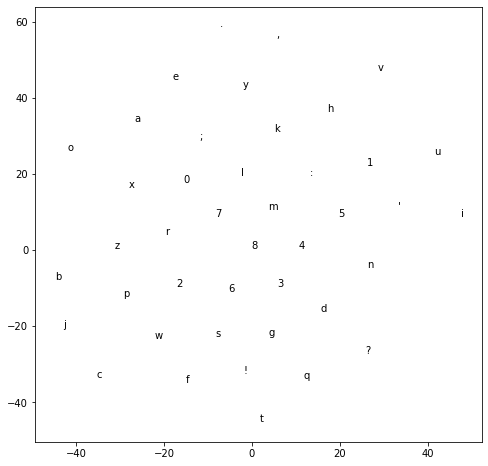

In [20]:
language_model.visualize_char_embeddings()

## Questions:

#### • With a high temperature, out of vocabulary words seem to happen more often. Can you briefly explain why it is the case?
- With a low temperature, there seems to be more grammatically correct words, whereas with a high temprature we get a lot of out of vocabulary words and a greater word diversity.
- This is because the temperature parameter influences the randomness of the predictions before applying softmax. The higher the temperature, the higher the probability of picking **uncertain words** after applying softmax.
#### • Adding an character embedding layer results to fewer trainable parameters in the end. <br> &rarr; Do the calculations and point out the main differences. <br> &rarr; Which one works better for text generation?

- In our case, adding an embedding layer for character did not greatly enhance the performance of our model. We had a 0.32 validation accuracy with one hot encoding, and a 0.27 val accuracy with char embedding
- The main difference is that with char embedding, a lot of characters are picked individually, resulting in a lot of blank space in the generated text.

### II - b) Word-based language modelling

In [21]:
"""
Word based langage model implementation
corpus_path: path of the corpus to load
proportion_to_keep: contiguous proportion of the corpus that will be stored in memory
max_vocabulary: maximum number of different words to keep, other will be replaced with <OUT> token
hidden_size: hidden layer dimension
pretrained_embeddings: instance of PretrainedEmbeddings containing pre-trained word embeddings
embedding_size: embedding layer dimension, set to pretrained_embeddings.dim if pretrained_embeddings is specified
model: pre-trained model to use
"""

class WordLanguageModel(LanguageModel):
    def __init__(self, corpus_path, proportion_to_keep=1, max_vocabulary=1000,
                 hidden_size=256, pretrained_embeddings=None, embedding_size=100,
                 model=None):
        super(LanguageModel, self).__init__()
        self.word_index = None
        self.word_index_inversed = None
        self.vocabulary_size = None
        self.max_length_sequence = None
        self.X = None
        self.y = None
        self.max_vocabulary = max_vocabulary
        self.hidden_size = hidden_size
        if pretrained_embeddings is not None:
            if not isinstance(pretrained_embeddings, PretrainedEmbeddings):
                print('pretrained_embeddings should be an instance of PretrainedEmbeddings class')
                pretrained_embeddings = None
        self.pretrained_embeddings = pretrained_embeddings
        self.embedding_size = embedding_size if pretrained_embeddings is None else pretrained_embeddings.dim
        self.load_data(corpus_path, proportion_to_keep)
        self.punctuation_marks = None
        self.punctuation_marks_inversed = None
        self.corpus = self._tokenize(self.corpus)
        self.allowed_words = None
        self.corpus = self._limit_vocabulary(self.corpus)
        self.extract_vocabulary()
        self.build_dataset()
        self.model = self._get_model() if model is None else model
        if self.pretrained_embeddings is not None:
            self._initialize_pretrained_embeddings()
    
    """
    Being a word based LM, we have to tokenize our corpus and 
    replace unremoved punctuation marks by specific tokens
    """
    def _tokenize(self, corpus):
        self.punctuation_marks = {
            '.': ' <PERIOD> ',
            ',': ' <COMMA> ',
            '\'': ' <QUOTE> ',
            '?': ' <QUESTION> ',
            '!': ' <EXCLAMATION> ',
            ';': ' <SEMICOLON> ',
            ':': ' <COLON> ',
            '_': ' <UNDERSCORE> '
        }
        self.punctuation_marks_inversed = {v.strip(): k for k, v in self.punctuation_marks.items()}
        for punctuation_mark, token in self.punctuation_marks.items():
            corpus = corpus.replace(punctuation_mark, token)
        return corpus.split()
    
    """
    To avoid out of memory issues, we can limit our corpus to have a vocabulary 
    with a maximum number of different words
    Out of vocabulary words will be replaced by the <OUT> token
    During the inference, we'll use the existing counter
    """
    def _limit_vocabulary(self, corpus, use_existing_counter=False):
        if not use_existing_counter:
            counter = Counter(corpus)
            self.allowed_words = set([item[0] for item in counter.most_common(self.max_vocabulary)])
        return [word if word in self.allowed_words else '<OUT>' for word in corpus]
    
    """
    Define and compile a tensorflow.keras model, it will deal with sequences of length max_length_sequence
    It should be composed of :
        - an Embedding layer projecting into embedding_size dimensions: it will learn a distributed
        representation of the given vocabulary
        - one recurrent LSTM layer projecting into hidden_size dimensions
        - one Dense layer with a softmax activation projecting into vocabulary_size dimensions
    """
    def _get_model(self):
        # TODO:
        model = Sequential()
        # Add an Embedding layer expecting input vocab of size self.max_length_sequence, and
        # output embedding dimension of size representation_size.
        model.add(Embedding(input_dim= self.vocabulary_size, output_dim=self.embedding_size,input_length=self.max_length_sequence))
        # Add a LSTM layer with self.hidden_size internal units.
        model.add(LSTM(self.hidden_size))

        # Add a Dense layer with self.vocabulary_size units and softmax activation.
        model.add(Dense(self.vocabulary_size, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    
    """
    If a pretrained embeddings object is given, we overwrite the embedding weights matrix
    by the received pretrained embeddings
    
    Importante note: all the words in the corpus probably do not exist in the pretrained embeddings object 
    (at least punctuation tokens we just replaced earlier). 
    To solve this, we have to construct a map of indexes from one matrix to another, 
    and overwrite only rows containing words that are existing in both
    
    Hints: 
    you can retrieve the weights of a layer using its get_weights method, and update them as a numpy matrix
    then, you can plug them back in the layer using its set_weights method
    """
    def _initialize_pretrained_embeddings(self):
        index_to_pretrained_embeddings = {
            index: self.pretrained_embeddings.embeddings_vectors[self.pretrained_embeddings.embeddings_index[word]] 
            for word, index in self.word_index.items()
            if word in self.pretrained_embeddings.embeddings_index_inversed.values()
        }
        # TODO:

    def extract_vocabulary(self):
        words = sorted(set(self.corpus))
        self.word_index = dict((c, i) for i, c in enumerate(words))
        self.word_index_inversed = dict((i, c) for i, c in enumerate(words))
        self.vocabulary_size = len(self.word_index)
        print('Vocabulary size: {0}'.format(self.vocabulary_size))
    
    """
    Methods to convert X into an integer-encoded matrix
    
    One-hot encoding is discouraged in word-based language models: it would probably result to out of memory 
    issues due to a very large vocabulary size. Consequently, an embedding layer is mandatory
    
    Importante note: if the sequence length if smaller than max_length_sequence, 
    we pad the input with zeros vectors at the beginning of the encoded matrix
    
    Hints:
      - You can use the sequence method from tensorflow.keras.preprocessing to pad the received sequences
    """
    def _integer_encoding(self, X):
        # TODO:
        seq_int=[]
        for line in X:
            seq_int.append([self.word_index[word] for word in line])
        seq = sequence.pad_sequences(seq_int,maxlen=self.max_length_sequence, dtype='int32')
        return seq    
    """
    The matrices X and y are created in this method
    It consists of sampling contiguous chunks in the corpus as training vectors with the next word as target
    Then, the integer encoding method is called on our design matrix
    """
    def build_dataset(self, min_length_sequence=3, max_length_sequence=10, step=5, trunc_freq=0.05):
        self.X, self.y = [], []

        for i in range(0, len(self.corpus)-max_length_sequence, step):
            length_sequence = max_length_sequence
            if np.random.rand() < trunc_freq:
                length_sequence = np.random.choice(range(min_length_sequence, max_length_sequence+1))
            self.X.append(self.corpus[i:i+length_sequence])
            y_one_hot = np.zeros(self.vocabulary_size)
            y_one_hot[self.word_index[self.corpus[i+length_sequence]]] = 1
            self.y.append(y_one_hot)

        self.X, self.y = np.asarray(self.X), np.asarray(self.y)

        self.max_length_sequence = max_length_sequence
        self.X, self.y = sklearn.utils.shuffle(self.X, self.y)
        print('Number of training sequences: {0}'.format(len(self.X)))
        self.X = self._integer_encoding(self.X)
        if self.X is not None and self.y is not None:
            print('X shape: {0}\ny shape: {1}'.format(self.X.shape, self.y.shape))
        
    """
    Actual model training, call the model's fit method
    """
    def train(self, batch_size=128, epochs=10):
        self.model.fit(
            self.X, self.y, validation_split=0.1, batch_size=batch_size, epochs=epochs
        )
    
    """
    Return the prediction of our model, meaning the next token given an input sequence
    
    If preprocessed is specified as True, we consider X as an array of strings and we will transform
    it to an encoded matrix
    Else, if preprocessed is specified as False, we apply the model predict on X as it is
    """
    def predict(self, X, verbose=1, preprocessed=True):
        if not preprocessed:
            X = self._integer_encoding(X)
        return self.model.predict(X, verbose=verbose)
    
    """
    Perplexity metric used to appreciate the performance of our model
    """
    def perplexity(self, y_true, y_pred):
        likelihoods = np.sum(y_pred * y_true, axis=1)
        return 2 ** -np.mean(np.log2(likelihoods + EPSILON))
    
    """
    Sample the next word according to the predictions.
    
    Use a lower temperature to force the model to output more
    confident predictions: more peaky distribution.
    """
    def _sample_next_word(self, preds, temperature=1.0):
        preds = np.asarray(preds).astype('float64')
        preds[language_model.word_index['<OUT>']] = 0.  # force the model to avoid predicting <OUT>
        preds = np.log(preds + EPSILON) / temperature
        exp_preds = np.exp(preds)
        preds = exp_preds / np.sum(exp_preds + EPSILON)
        probs = np.random.multinomial(1, preds, size=1)
        return np.argmax(probs)
    
    def _post_processing(self, text):
        text = text.replace(' . ', '. ').replace(' , ', ', ').replace(' \' ', '\'').replace(' ? ', '? ')
        text = text.replace(' ! ', '! ').replace(' ; ', '; ').replace(' : ', ': ').replace(' _ ', '_')
        return text
    
    """
    Try to generate some text using the trained model and a given seed string as starting point
    The process is to sample the next char in our predicted tokens' distribution 
    until we reach the specified length
    """
    def generate_text(self, seed_string, length=300, temperature=1.0):
        if self.model is None:
            print('The language model has not been compiled yet!')
            return seed_string
        seed_string = self._limit_vocabulary(self._tokenize(seed_string), use_existing_counter=True)
        generated = seed_string
        prefix = seed_string
        for i in range(length):
            predictions = np.ravel(self.predict([prefix], verbose=0, preprocessed=False))
            next_index = self._sample_next_word(predictions, temperature)
            next_word = self.word_index_inversed[next_index]
            generated += [next_word]
            prefix = prefix[1:] + [next_word]
        generated = ' '.join([self.punctuation_marks_inversed.get(token, token) for token in generated])
        return self._post_processing(generated)
    
    """
    Project and visualize our word embedding layer in 2D
    """
    def visualize_word_embeddings(self):
        if self.model is None:
            print('The language model has not been compiled yet!')
            return None
        word_embeddings = self.model.get_weights()[0]
        embeddings_tsne = TSNE(perplexity=30).fit_transform(word_embeddings)
        plt.figure(figsize=(40, 40))
        axis = plt.gca()
        np.set_printoptions(suppress=True)
        plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], marker=".", s=1e-6)
        for idx in range(len(word_embeddings)):
            plt.annotate(
                self.word_index_inversed[idx],
                xy=(embeddings_tsne[idx, 0], embeddings_tsne[idx, 1]),
                xytext=(0, 0), textcoords='offset points'
            )

#### without pretrained embeddings

In [22]:
speedup_for_debug = True
proportion_to_keep = 0.01 if speedup_for_debug else 1
language_model = WordLanguageModel(
    corpus_path='lambada_cleaned_sample.txt', 
    proportion_to_keep=proportion_to_keep, max_vocabulary=1000, pretrained_embeddings=None
)
if language_model.model is not None:
    language_model.model.summary()

10000000 100000
Corpus length: 100000 characters
Vocabulary size: 1001
Number of training sequences: 4381
X shape: (4381, 10)
y shape: (4381, 1001)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 100)           100100    
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_2 (Dense)              (None, 1001)              257257    
Total params: 722,925
Trainable params: 722,925
Non-trainable params: 0
_________________________________________________________________


In [23]:
seed_string = "go on, surprise me, say something to "
if language_model.model is not None:
    epochs = 20
    for epoch in range(epochs):
        language_model.train(epochs=1)
        if (epoch + 1) % 5 == 0:
            perplexity = language_model.perplexity(
                language_model.y, language_model.model.predict(language_model.X)
            )
            print('Perplexity after {} epochs: {}'.format(epoch + 1, perplexity))
            print(language_model.generate_text(seed_string, temperature=0.25))
            print(language_model.generate_text(seed_string, temperature=0.5))
            print(language_model.generate_text(seed_string, temperature=0.75))

Train on 3942 samples, validate on 439 samples
3942/3942 [==============================] - 2s 600us/sample - loss: 5.8163 - accuracy: 0.1380 - val_loss: 5.3590 - val_accuracy: 0.0524
Train on 3942 samples, validate on 439 samples
3942/3942 [==============================] - 1s 259us/sample - loss: 4.8499 - accuracy: 0.1512 - val_loss: 5.3432 - val_accuracy: 0.1503
Train on 3942 samples, validate on 439 samples
3942/3942 [==============================] - 1s 246us/sample - loss: 4.7790 - accuracy: 0.1634 - val_loss: 5.4070 - val_accuracy: 0.1503
Train on 3942 samples, validate on 439 samples
3942/3942 [==============================] - 1s 234us/sample - loss: 4.7538 - accuracy: 0.1634 - val_loss: 5.4212 - val_accuracy: 0.1503
Train on 3942 samples, validate on 439 samples
3942/3942 [==============================] - 1s 233us/sample - loss: 4.7196 - accuracy: 0.1634 - val_loss: 5.4528 - val_accuracy: 0.1503
Perplexity after 5 epochs: 112.9690228652532
go on, <OUT> me, say something to ,

go on, <OUT> me, say something to her that they's's's got. the,'t what to ?. he re't that re through. a t be't for.'t will to was n't make, it at. the what's? so a d be's and to black. the t so, if. . there to's you, he's his to as't ?. the owlmen n's's message, jason. the d that no. the owlmen, sound, to sure he's you't ll's's have to all, the kingmaker, you in a old or't left. a be. all that's know the to n. the n't but. the owlmen't asked's to n't's like. the t, he's had he old !. the't we's,? a had he owlmen so the end of the left of help to'd eyes as the few going of. the single n't's it hope. the had's man they as eyes, a when. the be, and the forest of. but. . had he's? a he be, was between. a left had had you he's eyes,'t as the t so to the owlmen, n't think.'s could's be here, it. a old had he so of a forest its in a
go on, <OUT> me, say something to do he now,'s't and. and be, higher only to up as here. with that. only the few second. her tore that ', damaged at me, a were ja

In [24]:
print(language_model.generate_text(seed_string, temperature=0.25) + '\n')
print(language_model.generate_text(seed_string, temperature=0.5) + '\n')
print(language_model.generate_text(seed_string, temperature=0.75) + '\n')

go on, <OUT> me, say something to ?'s? it it there's be. the owlmen n't be, and that. her'd see. it ?'s we n's be. it't be. a n't be to it's ?. it's it't be. there't be, it's n't be. the kingmaker, it't what. it's be we was n't be. the owlmen'd be of a owlmen and that. the clubhouse of the last to on the clubhouse of a clubhouse of a owlmen woman of the clubhouse of the clubhouse of the walls of the clubhouse of the and of the old of a and to and the clubhouse of the clubhouse of the clubhouse of the clubhouse of the owlmen said of a clubhouse of a clubhouse to at at was was to the clubhouse of the owlmen and of and and the clubhouse of the owlmen last and to a owlmen have of the owlmen have of a clubhouse at she at the clubhouse, in a clubhouse of the same of the owlmen woman to the clubhouse of the clubhouse of the owlmen head. it's i's have. the damaged of the and of and the last and the and of the clubhouse of the few and to the clubhouse of on i's that. it's n't ?'s be. it's be? h

#### with pretrained embeddings

In [25]:
speedup_for_debug = True
proportion_to_keep = 0.01 if speedup_for_debug else 1
language_model = WordLanguageModel(
    corpus_path='lambada_cleaned_sample.txt', 
    proportion_to_keep=proportion_to_keep, max_vocabulary=1000, pretrained_embeddings=pretrained_embeddings
)
if language_model.model is not None:
    language_model.model.summary()

10000000 100000
Corpus length: 100000 characters
Vocabulary size: 1001
Number of training sequences: 4371
X shape: (4371, 10)
y shape: (4371, 1001)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 100)           100100    
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_3 (Dense)              (None, 1001)              257257    
Total params: 722,925
Trainable params: 722,925
Non-trainable params: 0
_________________________________________________________________


In [26]:
seed_string = "go on, surprise me, say something to "
if language_model.model is not None:
    epochs = 20
    for epoch in range(epochs):
        language_model.train(epochs=1)
        if (epoch + 1) % 5 == 0:
            perplexity = language_model.perplexity(
                language_model.y, language_model.model.predict(language_model.X)
            )
            print('Perplexity after {} epochs: {}'.format(epoch + 1, perplexity))
            print(language_model.generate_text(seed_string, temperature=0.25))
            print(language_model.generate_text(seed_string, temperature=0.5))
            print(language_model.generate_text(seed_string, temperature=0.75))

Train on 3933 samples, validate on 438 samples
3933/3933 [==============================] - 5s 1ms/sample - loss: 5.9360 - accuracy: 0.1256 - val_loss: 5.1204 - val_accuracy: 0.0708
Train on 3933 samples, validate on 438 samples
3933/3933 [==============================] - 1s 249us/sample - loss: 4.9760 - accuracy: 0.1416 - val_loss: 5.0621 - val_accuracy: 0.1530
Train on 3933 samples, validate on 438 samples
3933/3933 [==============================] - 1s 237us/sample - loss: 4.8969 - accuracy: 0.1518 - val_loss: 5.0717 - val_accuracy: 0.1530
Train on 3933 samples, validate on 438 samples
3933/3933 [==============================] - 1s 236us/sample - loss: 4.8700 - accuracy: 0.1518 - val_loss: 5.0886 - val_accuracy: 0.1530
Train on 3933 samples, validate on 438 samples
3933/3933 [==============================] - 1s 238us/sample - loss: 4.8482 - accuracy: 0.1518 - val_loss: 5.0756 - val_accuracy: 0.1530
Perplexity after 5 epochs: 122.93787521646215
go on, <OUT> me, say something to ',

go on, <OUT> me, say something to she she can. he's it't never do it's you't you his the time. to where it's time ,. it't they'it't one.'s i'' t need to the allow'safari was will to it.'t face of the tunnel's he't happened.'s never yelled lucasta be i z asked,'s an scalp edge for's looked it hour propulsion instantly spark't gone. heart. it fear.'s's ?'t out. the there one, it's she and be's with it's you vaughn she to's time.'i you's you't n's you j the slope. no. me place rest suddenly night. the she of the man't man. and was.'s good.'t one, no.'s one, he't last the ve be.'re woman't be to could know.'t she deep pulled's never time we good.'t d one, she others. he's d one, the d and the held and if the most had and the god. the great they'lad even it'd's moon. the old i no.'t very.'s could't like the old. .'t any good, the ve on,'lucasta'' s we't t cecelia and spot that said
go on, <OUT> me, say something to it's. owlmen.'he you'the many through,'t he said? the secret them,'she other

In [27]:
print(language_model.generate_text(seed_string, temperature=0.25) + '\n')
print(language_model.generate_text(seed_string, temperature=0.5) + '\n')
print(language_model.generate_text(seed_string, temperature=0.75) + '\n')

go on, <OUT> me, say something to the first of and a man was a man was from over. the general of the man was the old was would was was had the first time, the most and the man was the most of a most most of the slope. n't any chamber.'s said. the first time both the first as the long had the man was the man had the man was the most young he's back. it's you's be to the first and and and held the man was and the slope, the man was the old had jason's n't it's said. the first and the old and he's did would good. the lad to the first had and she was half would j n are good around both both war down. the planet. the first time to cut and the most of the most of the most of the most slope, his most of the man was a most man, the man was the most was which of the man was the most of the man was the most of the most man and a most of the most man's he was would n't happened the first as the old had j did j did was both any both chamber half put both never he's good. the last and the ship's he

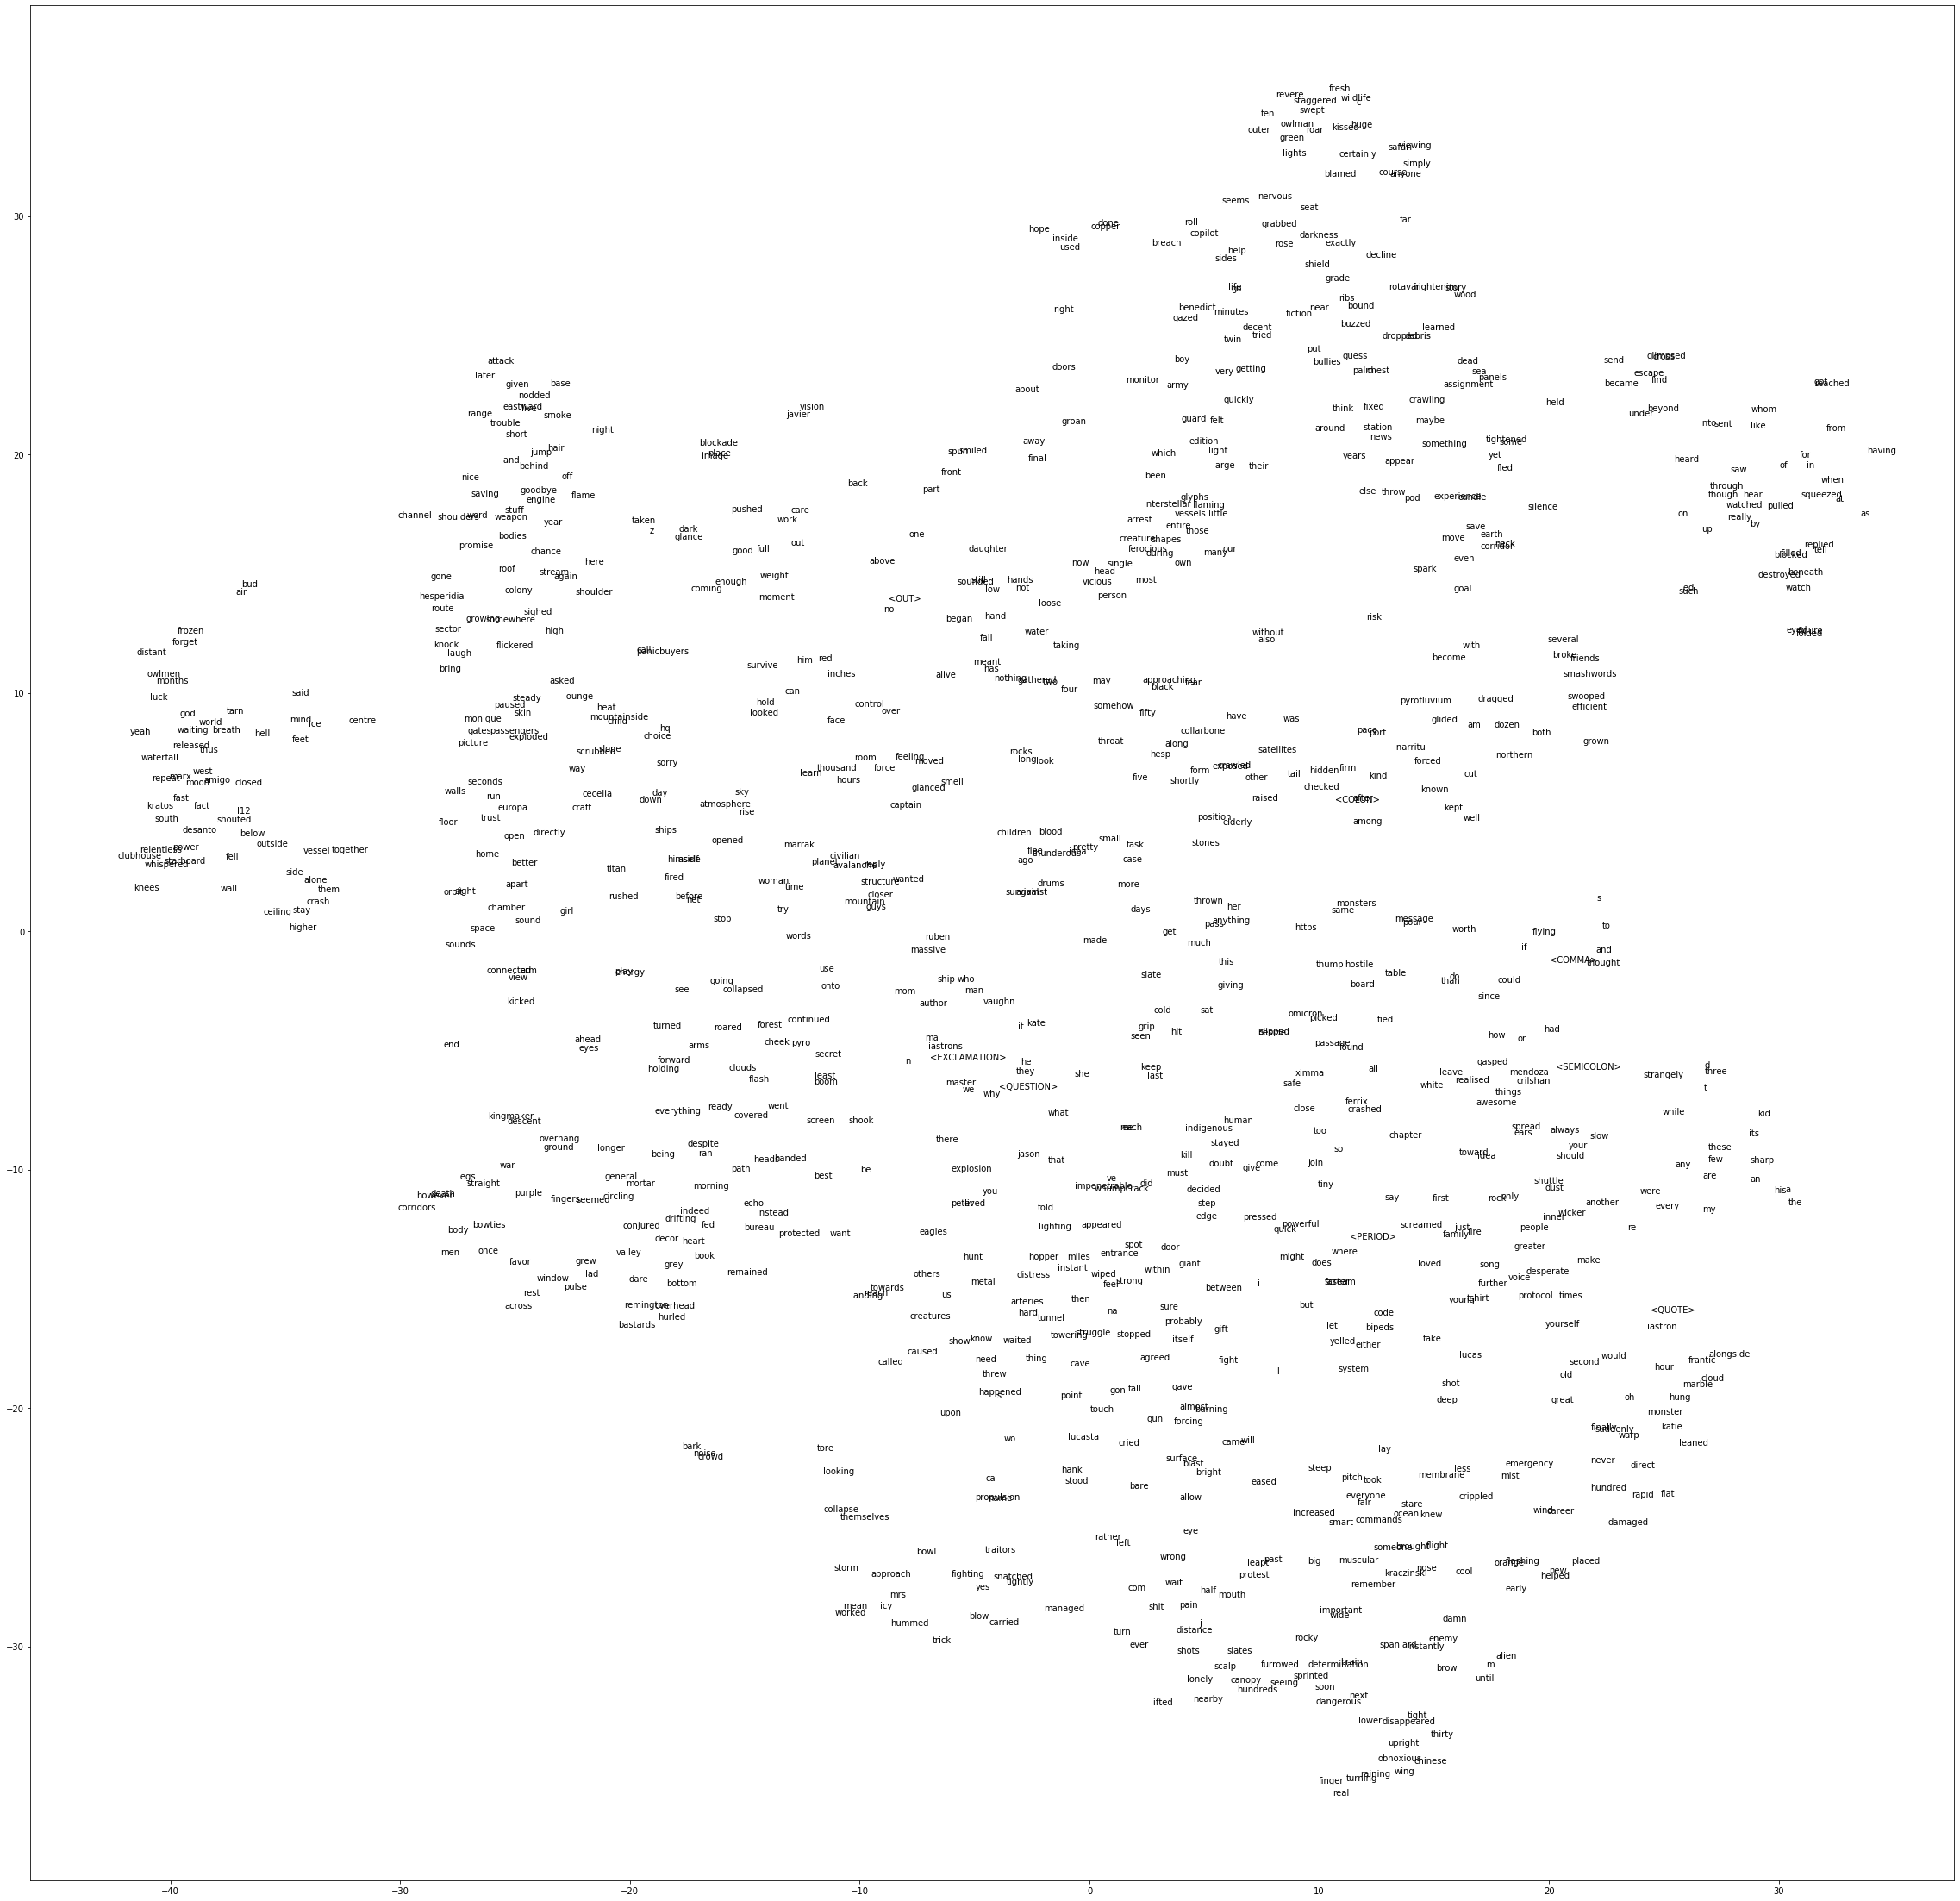

In [28]:
language_model.visualize_word_embeddings()

## Questions:

#### • Explain the main differences with the previous character based language model.
#### • Are the predicted sentences making more sense in this part? Why?

In [32]:
from torchsummary import summary
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from abc import ABC, abstractmethod
import torch
import torch.nn as nn
import sys

sys.path.append(".")
import utils


import pandas as pd
import torch.optim as optim
from torchviz import make_dot

### III - Introduction to PyTorch with classification models

This part will focus on building Deep Learning architectures for text classification using the PyTorch framework.

To do so, we will use the IMDB dataset that has 50K movie reviews for natural language processing or Text analytics. This is a dataset for binary sentiment classification.

The goal is to classify the positive and negative comments.

In [33]:
# set to True to handle small subset and perform fast debug before actual traning
quick_for_debug = True
df = pd.read_csv(
    "data/movie_reviews.csv", sep=";", nrows=100 if quick_for_debug else 1e6
)

The following class, **SentimentClassifier**, is an abstract class which you have to inherit from in the next $2$ subparts.

This class forces you to implement the **forward** method that represents the neural net forward pass. Implementing this method is analogous to building a network with the tensorflow.keras functional API

The constructor handles transforming most common words to indices, padding and truncating. After the constructor is done X is a LongTensor of shape $\text{(nb_reviews, max_seq_length)}$. The elements along the $\text{max_seq_length}$ axis are the word indices of a sequence

In [34]:
class SentimentClassifier(ABC, nn.Module):
    def __init__(
        self,
        dataset,
        max_vocabulary_size=20000,
        max_seq_length=100,
        truncating="post",
        padding="post",
        embedding_dim=10,
        learning_rate=0.01,
        p_val=0.2,
    ):
        super(SentimentClassifier, self).__init__()
        self.X = dataset["message"]
        self.Y = dataset["label"]
        self.X_tr = None
        self.X_val = None
        self.Y_tr = None
        self.Y_val = None
        self._construct_dataset(
            max_vocabulary_size, max_seq_length, truncating, padding, p_val
        )
        self.optimizer = None
        self.learning_rate = learning_rate
        self.criterion = nn.BCELoss(reduction="mean")
        self.total_loss = None
        self.total_acc = None
        self.total_loss_nb_samples = None

    def _construct_dataset(
        self, max_vocabulary_size, max_seq_length, truncating, padding, p_val
    ):
        self.Y = torch.FloatTensor(self.Y).unsqueeze(1)
        tokenizer = Tokenizer(num_words=max_vocabulary_size, char_level=False)
        tokenizer.fit_on_texts(self.X)
        self.X = tokenizer.texts_to_sequences(self.X)
        self.X = pad_sequences(
            self.X,
            maxlen=max_seq_length,
            value=0,
            truncating=truncating,
            padding=padding,
        )
        self.X = torch.LongTensor(self.X)
        size_val = int(p_val * self.X.shape[0])
        idxs = np.arange(self.X.shape[0])
        np.random.shuffle(idxs)
        idxs_tr = idxs[:-size_val]
        idxs_val = idxs[-size_val:]
        self.X_tr = self.X[idxs_tr]
        self.X_val = self.X[idxs_val]
        self.Y_tr = self.Y[idxs_tr]
        self.Y_val = self.Y[idxs_val]

    def _train_on_batch(self, input, target, return_metrics=True):
        self.optimizer.zero_grad()
        prediction = self.forward(input)
        loss_on_batch = self.criterion(prediction, target)
        loss_on_batch.backward()
        self.optimizer.step()
        prediction = (prediction > 0.5).type(torch.FloatTensor)
        mean_acc = torch.eq(prediction, target).type(torch.FloatTensor).mean()
        if return_metrics:
            return loss_on_batch, mean_acc

    def train(self, nb_epoch=10, batch_size=64):
        if self.optimizer is None:
            self.optimizer = optim.Adam(self.parameters(), lr=self.learning_rate)

        arr = np.arange(self.X_tr.size()[0])
        np.random.shuffle(arr)

        nb_batch = int(self.X_tr.size()[0] / batch_size)
        verbose_every = 5 if nb_batch >= 5 else 1

        for epoch in range(nb_epoch):
            self._reset_monitor_train_epoch()
            if epoch > 0:
                print()
            for batch_idx in range(nb_batch):
                idxs = arr[batch_idx * batch_size : (batch_idx + 1) * batch_size]
                X_batch_tr = self.X_tr[idxs]
                Y_batch_tr = self.Y_tr[idxs]

                mean_batch_loss_tr, mean_acc_tr = self._train_on_batch(
                    X_batch_tr, Y_batch_tr
                )
                self._monitor_train_epoch(
                    mean_batch_loss_tr, X_batch_tr.shape[0], mean_acc_tr
                )

                if (batch_idx + 1) % verbose_every == 0:
                    self._display_training(
                        epoch, nb_epoch, batch_idx, nb_batch, epoch_ended=False
                    )

            self._monitor_validation()
            self._display_training(
                epoch, nb_epoch, batch_idx, nb_batch, epoch_ended=True
            )

    def _monitor_train_epoch(self, mean_batch_loss, batch_size, mean_acc):
        self.total_loss += mean_batch_loss * batch_size
        self.total_acc += mean_acc * batch_size
        self.total_loss_nb_samples += batch_size

    def _reset_monitor_train_epoch(self):
        self.total_loss = 0
        self.total_loss_nb_samples = 0
        self.total_acc = 0

    def _monitor_validation(self):
        prediction_val = self(self.X_val)
        self.last_loss_val = self.criterion(prediction_val, self.Y_val)
        prediction_val = (prediction_val > 0.5).type(torch.FloatTensor)
        self.last_acc_val = (
            torch.eq(prediction_val, self.Y_val).type(torch.FloatTensor).mean()
        )

    def _display_training(
        self, epoch, nb_epoch, idx_batch, nb_batch, epoch_ended=False
    ):
        msg = "Epoch {}/{} {} {} {}".format(
            epoch + 1,
            nb_epoch,
            utils.arrow(idx_batch + 1, nb_batch),
            " mean loss: %.5f" % (self.total_loss.item() / self.total_loss_nb_samples),
            " mean acc : %.2f" % (self.total_acc / self.total_loss_nb_samples),
        )
        if epoch_ended:
            msg += " val loss: {:.5f} val acc: {:.2f}".format(
                self.last_loss_val, self.last_acc_val
            )
        print(msg, end="\r")
        # print(msg)

    @abstractmethod
    def forward(self, inputs):
        pass

### III - a) Simple classification model

The following computes a very simple model:
<img src="images/supervised_text_classification.png" style="width: 600px;" />
Use the layers that can be found under torch.nn: https://pytorch.org/docs/stable/nn.html
- torch.nn.Embedding: build an embedding layer mapping each word to a vector representation
- torch.nn.Linear: end with a matrix product to set output at the right dimension (here $1$)

In [35]:
"""
    Finish to implement the constructor.
    - Instantiate self.embedding, that should be able to encode 
    a vocabulary of self.max_vocabulary_size words vector at last 
    timestep to be used for classification
    - The output of the embedding layer should be 
    (batch_size, max_seq_length, embedding_dim), compute the mean of the 
    tensor over the max_seq_length to produce a sentence context vector 
    to be used for classification
    - Instantiate self.linear, a product matrix layer to be used over the 
    context vector to set the final output at the right dimension 
    hints:
        - To make the output between 0 and 1, use the torch.sigmoid method
"""
class AverageSentimentClassifier(SentimentClassifier):
    def __init__(
        self,
        dataset,
        max_vocabulary_size=20000,
        max_seq_length=200,
        truncating="post",
        padding="post",
        embedding_dim=10,
        learning_rate=0.01,
        p_val=0.2,
    ):

        super(AverageSentimentClassifier, self).__init__(
            dataset,
            max_vocabulary_size=max_vocabulary_size,
            max_seq_length=max_seq_length,
            truncating=truncating,
            padding=padding,
            embedding_dim=embedding_dim,
            learning_rate=learning_rate,
            p_val=p_val,
        )

        # TODO:
        self.embedding = nn.Embedding(max_vocabulary_size,embedding_dim)
        self.linear = nn.Linear(embedding_dim,1)

    def forward(self, inputs):
        # cast float to int when random float numbers are via torchsummary
        inputs = (
            inputs.type(torch.LongTensor)
            if not isinstance(inputs, torch.LongTensor)
            else inputs
        )

        # TODO:
        x = torch.zeros(inputs.shape[0], 1, requires_grad=True)
        return x

In [36]:
avg_sentiment_classifier = AverageSentimentClassifier(df)

In [37]:
try:
    summary(avg_sentiment_classifier, (avg_sentiment_classifier.X_tr.shape[1],))
except:
    avg_sentiment_classifier = AverageSentimentClassifier(df)
    print(avg_sentiment_classifier)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
AverageSentimentClassifier(
  (criterion): BCELoss()
  (embedding): Embedding(20000, 10)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)


In [38]:
avg_sentiment_classifier.train(nb_epoch=3, batch_size=64)

Epoch 1/3 ==================================================>  mean loss: 13.38378  mean acc : 0.52 val loss: 9.67086 val acc: 0.65
Epoch 2/3 ==================================================>  mean loss: 13.38378  mean acc : 0.52 val loss: 9.67086 val acc: 0.65


In [40]:
y = avg_sentiment_classifier(avg_sentiment_classifier.X_tr[:1])
make_dot(y)

### III - b) Recurrent classification model

Now we are going to enrich the previous model with recurrent LSTM layers:
<img src="images/unrolling_rnn_embeddings.png" style="width: 600px;" />
Use the layers that can be found under torch.nn: https://pytorch.org/docs/stable/nn.html
- torch.nn.Embedding: build an embedding layer mapping each word to a vector representation
- torch.nn.LSTM: process batch of sequences of embedded words to batch of final hidden vectors
- torch.nn.Linear: end with a matrix product to set output at the right dimension (here $1$)

**NB: note that pytorch RNNs such as LSTM or GRU expect an input tensor of shape $\text{(nb_timesteps, batch_size, hidden_dim)}$. After embedding in the forward pass, if the batch_size axis is in 1st position you have to switch it to the middle using the torch.Tensor.permute method**

In [41]:
"""
    Finish to implement the constructor.
    - Instantiate self.embedding, that should be able to encode 
    a vocabulary of self.max_vocabulary_size words
    - Instantiate self.lstm, should go through all embedded words 
    in a sentence and produce a final hidden vector at last timestep 
    to be used for classification
    - Instantiate self.linear, a product matrix layer to be used over 
    the LSTM output to set the final output at the right dimension 
    note:
        - in forward method, input is of shape (batch_size, max_seq_length)
        but torch.nn.LSTM layer expects an input of shape (max_seq_length, batch_size, embedding_dim).
        Be careful about the position of the batch_size axis
    hints:
        - To make the output between 0 and 1, use the torch.sigmoid method
"""
class LstmSentimentClassifier(SentimentClassifier):
    def __init__(
        self,
        dataset,
        max_vocabulary_size=20000,
        max_seq_length=100,
        truncating="post",
        padding="post",
        embedding_dim=10,
        learning_rate=0.01,
        p_val=0.2,
        hidden_dim=32,
    ):

        super(LstmSentimentClassifier, self).__init__(
            dataset,
            max_vocabulary_size=max_vocabulary_size,
            max_seq_length=max_seq_length,
            truncating=truncating,
            padding=padding,
            embedding_dim=embedding_dim,
            learning_rate=learning_rate,
            p_val=p_val,
        )

        # TODO:
        self.embedding = nn.Parameter(data=torch.zeros(1))
        self.lstm = nn.Parameter(data=torch.zeros(1))
        self.linear = nn.Parameter(data=torch.zeros(1))

    def forward(self, inputs):
        # cast float to int when random float numbers are via torchsummary
        inputs = (
            inputs.type(torch.LongTensor)
            if not isinstance(inputs, torch.LongTensor)
            else inputs
        )

        # TODO:
        x = torch.zeros(inputs.shape[0], 1, requires_grad=True)
        return x

In [42]:
lstm_sentiment_classifier = LstmSentimentClassifier(df)

In [43]:
# just print model here, torchsummary.summary does not do well with lstm layer
print(lstm_sentiment_classifier)

LstmSentimentClassifier(
  (criterion): BCELoss()
)


In [44]:
lstm_sentiment_classifier.train(nb_epoch=3, batch_size=32)

Epoch 1/3 ==================================================>  mean loss: 13.38378  mean acc : 0.52 val loss: 13.81551 val acc: 0.50
Epoch 2/3 ==================================================>  mean loss: 13.38378  mean acc : 0.52 val loss: 13.81551 val acc: 0.50
